# Airbnb Model Evaluation

In [1]:
#importing packages
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql import SparkSession
import pandas as pd
import pyspark
import matplotlib.pyplot as plt

In [2]:
#loading a custom function from this gist: https://gist.github.com/HerveMignot/a8f18e52b31d11c21132ef624249a887
def plot_confusion_matrix(ddf, labelCol, predictionCol, title=None, normalize=False):
    '''Plot a Confusion Matrix in a scalable way
    Confusion matrix is computed with Spark to leverage scalability.
    Only aggregated data are sent back to Python, doing the final formatting on the matrix locally.
    Parameters
    ----------
    ddf: Spark DataFrame (pyspark.sql.dataframe.DataFrame)
    labelCol: label column name (string)
    predictionCol: prediction column name (string)
    title: title string to be added
    normalize : bool, {'all', 'index', 'columns'}, or {0, 1}, default False
        Normalize by dividing all values by the sum of values.
        - If passed 'all' or `True`, will normalize over all values.
        - If passed 'index' will normalize over each row.
        - If passed 'columns' will normalize over each column.
        - If margins is `True`, will also normalize margin values.
        (see pandas.crosstab() for additional details)
    Returns
    -------
    Confusion matrix as matplotlib.axes._subplots.AxesSubplot
    '''
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.ticker import FuncFormatter

    if title:
        ax = plt.axes()
        ax.set_title(title)

    mat = (ddf.groupby([labelCol, predictionCol]).count().orderBy([labelCol, predictionCol])
              .toPandas())

    return sns.heatmap(pd.crosstab(mat[labelCol], mat[predictionCol], mat['count'], aggfunc='sum', normalize=normalize),
                       annot=True, fmt='d' if not normalize else '.2%',
                       cbar_kws={'format': FuncFormatter(lambda x, pos: '{:.0%}'.format(x))} if normalize else None,
                       cmap=plt.cm.Blues)

# Monkey patching a pyspark dataframe method
pyspark.sql.dataframe.DataFrame.plot_confusion_matrix = plot_confusion_matrix

### Loading Data

In [3]:
# Start spark session
spark = SparkSession.builder.getOrCreate()

In [4]:
# Read data in json format
train = spark.read.option("header",True).parquet("./data_preprocessed/train_data.parquet")
test = spark.read.option("header",True).parquet("./data_preprocessed/test_data.parquet")

### Loading Models

In [5]:
model_ridge = PipelineModel.load('./models/ridge.model')
model_lasso = PipelineModel.load('./models/lasso.model')
model_bayes = PipelineModel.load('./models/naive_bayes.model')
model_rf = PipelineModel.load('./models/random_forest.model')
model_gbt = PipelineModel.load('./models/gbt.model')

### Results Table

In [6]:
models = [
    model_ridge,
    model_lasso,
    model_bayes,
    model_rf,
    model_gbt
]

ClassEval = BinaryClassificationEvaluator()
OtherClassEval = MulticlassClassificationEvaluator()

training_auc = [ClassEval.evaluate(model.transform(train)) for model in models]
test_auc = [ClassEval.evaluate(model.transform(test)) for model in models]

training_acc = [OtherClassEval.evaluate(model.transform(train), {OtherClassEval.metricName: "accuracy"}) for model in models]
test_acc = [OtherClassEval.evaluate(model.transform(test), {OtherClassEval.metricName: "accuracy"}) for model in models]

training_f1 = [OtherClassEval.evaluate(model.transform(train), {OtherClassEval.metricName: "f1"}) for model in models]
test_f1 = [OtherClassEval.evaluate(model.transform(test), {OtherClassEval.metricName: "f1"}) for model in models]

training_1 = [OtherClassEval.evaluate(model.transform(train), {OtherClassEval.metricName: "weightedPrecision"}) for model in models]
test_1 = [OtherClassEval.evaluate(model.transform(test), {OtherClassEval.metricName: "weightedPrecision"}) for model in models]

training_2 = [OtherClassEval.evaluate(model.transform(train), {OtherClassEval.metricName: "weightedRecall"}) for model in models]
test_2 = [OtherClassEval.evaluate(model.transform(test), {OtherClassEval.metricName: "weightedRecall"}) for model in models]

training_3 = [OtherClassEval.evaluate(model.transform(train), {OtherClassEval.metricName: "weightedTruePositiveRate"}) for model in models]
test_3 = [OtherClassEval.evaluate(model.transform(test), {OtherClassEval.metricName: "weightedTruePositiveRate"}) for model in models]

training_4 = [OtherClassEval.evaluate(model.transform(train), {OtherClassEval.metricName: "weightedFalsePositiveRate"}) for model in models]
test_4 = [OtherClassEval.evaluate(model.transform(test), {OtherClassEval.metricName: "weightedFalsePositiveRate"}) for model in models]

results = pd.DataFrame({
    "Model_Name" : [
        "Ridge Logistic Regression",
        "Lasso Logistic Regression",
        "Naive Bayes",
        "Random Forest",
        "Gradient Boosted Tree"
    ],
    'Training Accuracy' : training_acc,
    'Test Accuracy' : test_acc,
    'Training AUC' : training_auc,
    'Test AUC' : test_auc,
    'Training F1' : training_f1,
    'Test F1' : test_f1,
    'Training Precision' : training_1,
    'Test Precision' : test_1,
    'Training Recall' : training_2,
    'Test Recall' : test_2,
    'Training TPR' : training_3,
    'Test TPR' : test_3,
    'Training FPR' : training_4,
    'Test FPR' : test_4
}).sort_values('Test AUC').T

results.columns = results.iloc[0,:].to_list()
results.drop(index = "Model_Name")

,Naive Bayes,Ridge Logistic Regression,Lasso Logistic Regression,Random Forest,Gradient Boosted Tree
Training Accuracy,0.618926,0.684212,0.684212,0.687851,0.691129
Test Accuracy,0.618028,0.686811,0.686811,0.689469,0.692706
Training AUC,0.67452,0.72121,0.72121,0.732884,0.741573
Test AUC,0.67506,0.720943,0.720946,0.732937,0.739274
Training F1,0.618922,0.672694,0.672694,0.677851,0.683501
Test F1,0.618067,0.675218,0.675218,0.679404,0.685122
Training Precision,0.618918,0.681858,0.681858,0.685154,0.687787
Test Precision,0.618107,0.683944,0.683944,0.686204,0.688898
Training Recall,0.618926,0.684212,0.684212,0.687851,0.691129
Test Recall,0.618028,0.686811,0.686811,0.689469,0.692706


From our table, it seems that overall both models performed around the same on the training and test set which is likely because we used crossvalidation.

We found that the highest performing model in this case is the Gradient Boosted Tree model with a test AUC of 0.73.

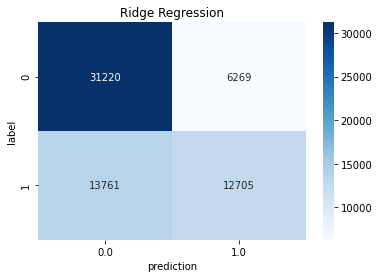

In [7]:
%matplotlib inline
model_ridge.transform(test).plot_confusion_matrix('label', 'prediction')
plt.title("Ridge Regression")
plt.savefig("plots/ridge", bbox_inches="tight")

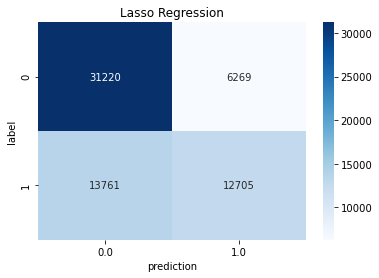

In [8]:
model_lasso.transform(test).plot_confusion_matrix('label', 'prediction')
plt.title("Lasso Regression")
plt.savefig("plots/lasso", bbox_inches="tight")

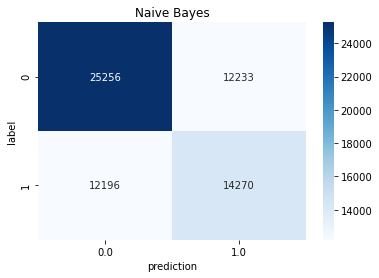

In [9]:
model_bayes.transform(test).plot_confusion_matrix('label', 'prediction')
plt.title("Naive Bayes")
plt.savefig("plots/nb", bbox_inches="tight")

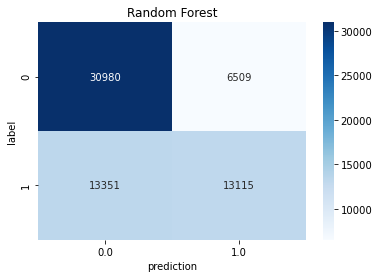

In [10]:
model_rf.transform(test).plot_confusion_matrix('label', 'prediction')
plt.title("Random Forest")
plt.savefig("plots/rf", bbox_inches="tight")

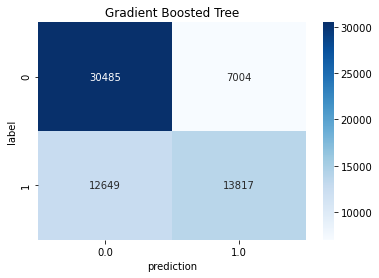

In [11]:
model_gbt.transform(test).plot_confusion_matrix('label', 'prediction')
plt.title("Gradient Boosted Tree")
plt.savefig("plots/gbt", bbox_inches="tight")